In [1]:
from mpl_toolkits import mplot3d
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
save_calib_fig = True
root_dir = '/home/elodie/KITTI_DATASET/object/training'
label_dir = '/home/elodie/Det3D'
#example_id = '000001'

fig_save_dir = '/home/elodie/det3D_Result'


colors_dict = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k'
}

axes_limits = [
    [-70.4, 70.4], # X axis range
    [-40, 40], # Y axis range
    [-10, 10]   # Z axis range
]

axes_str = ['X', 'Y', 'Z']

pos_cls = ['Car']
ign_cls = ['Van', 'Truck', 'Tram']

In [3]:
def get_files(pred_label_dir):
    examples = []
    directory = os.listdir(pred_label_dir)
    for dir in directory:
        examples.append(dir.replace('.txt', ''))
    return examples

In [4]:
def load_calibration(calib_file):
    with open(calib_file) as f:
        calib = [x.strip().split() for x in f.readlines()]
    P0 = np.array([float(i) for i in calib[0][1:]]).reshape((3, 4))
    P1 = np.array([float(i) for i in calib[1][1:]]).reshape((3, 4))
    P2 = np.array([float(i) for i in calib[2][1:]]).reshape((3, 4))
    P3 = np.array([float(i) for i in calib[3][1:]]).reshape((3, 4))
    R0_rect = np.eye(4, dtype='float32')
    R0_3x3 = np.array([float(i) for i in calib[4][1:]]).reshape((3, 3))
    R0_rect[:3, :3] = R0_3x3
    T_v2c = np.eye(4, dtype='float32')
    T_v2c[:3, :] = np.array([float(i) for i in calib[5][1:]]).reshape((3, 4))
    T_vel_to_cam = np.dot(R0_rect, T_v2c)

    calibs = {'P0': P0, 'P1': P1, 'P2': P2, 'P3': P3,
              'R0_rect': R0_rect,
              'T_v2c': T_v2c, 'T_vel_to_cam': T_vel_to_cam}
    return calibs

In [5]:
def label_to_bbox3d(labels):
    N = len(labels)
    ret = np.zeros((N, 8, 3), dtype=np.float32)

    for i in range(N):
        box = labels[i]
        translation = box[4:7]
        [h, w, l] = box[1:4]
        rotation = [0, 0, box[-1]]
        trackletBox = np.array([  # in velodyne coordinates around zero point and without orientation yet
            [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2], \
            [0, 0, 0, 0, -h, -h, -h, -h], \
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]])

        # re-create 3D bounding box in velodyne coordinate system
        yaw = rotation[2]
        rotMat = np.array([[np.cos(yaw), 0, np.sin(yaw)],
                           [0, 1, 0],
                           [-np.sin(yaw), 0, np.cos(yaw)]])
        cornerPosInVelo = np.dot(rotMat, trackletBox) + \
                          np.tile(translation, (8, 1)).T
        box3d = cornerPosInVelo.transpose()
        ret[i] = box3d
    return ret

In [6]:
def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.

    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = np.transpose(vertices)[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=1.5)

In [7]:
def display_single_lidar(data, example_id, label_name, boxes=None, points=0.2, view=False, calib=False ):
    # points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, data.shape[0], points_step)

    #print(points_step)
    #print(point_size)
    #print(velo_range)

    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        ax.scatter(*np.transpose(data[:, axes]), s=point_size, c=data[:, 3], cmap='gray')

        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])

        # User specified limits
        if xlim3d != None:
            ax.set_xlim3d(xlim3d)
        if ylim3d != None:
            ax.set_ylim3d(ylim3d)
        if zlim3d != None:
            ax.set_zlim3d(zlim3d)

        for i in range(boxes.shape[0]):
            if label_name[i] in colors_dict:
                draw_box(ax, boxes[i], axes=axes, color=colors_dict[label_name[i]])
            else:
                draw_box(ax, boxes[i], axes=axes, color='brown')
            # Draw point cloud data as 3D plot
            # f2 = plt.figure(figsize=(10, 5))
            # ax2 = f2.add_subplot(111, projection='3d')
            # ax2.view_init(45,45)

            # Hide grid lines
            # ax2.grid(False)
            #     plt.axis('off')

    # draw_point_cloud(ax2, 'Velodyne scan', xlim3d=axes_limits[0])
    # plt.show()

    if view:
        # Draw point cloud data as plane projections
        #         axe3.view_init(35,100)
        f, ax3 = plt.subplots(3, 1, figsize=(15, 25))
        
        draw_point_cloud(
            ax3[0],
            'Velodyne scan, XZ projection (Y = 0), the car is moving in direction left to right',
            axes=[0, 2]  # X and Z axes
        )
        draw_point_cloud(
            ax3[1],
            'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right',
            axes=[0, 1]  # X and Y axes
        )
        draw_point_cloud(
            ax3[2],
            'Velodyne scan, YZ projection (X = 0), the car is moving towards the graph plane',
            axes=[1, 2]  # Y and Z axes
        )
        if calib:
            fig_save_file = os.path.join(fig_save_dir, example_id, 'calib.png')
        else:
            fig_save_file = os.path.join(fig_save_dir, example_id, 'predictions.png')
        #plt.show()
        plt.savefig(fig_save_file)
        #plt.clf() # 使用 plt.clf() 清理掉 axes
        #plt.cla()
        plt.close('all')
        #plt.close(0)
        

In [8]:
def project_camera2velo(vel_data_c, calibs):
    # vel_data_c: col 0: back -> front
    #             col 1: down -> up
    #             col 2: left -> right

    vel_data = np.hstack((vel_data_c[:, :3], np.ones((vel_data_c.shape[0], 1), dtype='float32')))
    vel_data = np.dot(vel_data, np.linalg.inv(calibs['T_vel_to_cam'].T))
    # vel_data /= vel_data[:, -1].reshape((-1, 1))
    # vel_data = np.hstack((vel_data[:, :3], vel_data_c[:, -1].reshape((-1, 1))))

    return vel_data[:, :3]

In [9]:
def parse_label(labels):
    with open(labels, 'r') as fin:
        ret = []
        for line in fin.readlines():
            line = line.split(' ')# elodie
            [cls, truncated, occluded, alpha, lt_x, lt_y, rb_x, rb_y, h, w, l, x, y, z, rotation_y] = line[:15]# elodie
            #[cls, truncated, occluded, alpha, lt_x, lt_y, rb_x, rb_y, h, w, l, x, y, z, rotation_y] = line.split(' ') # elodie
            # if cls in pos_cls: # or  cls in ign_cls
            ret.append([cls, float(h), float(w), float(l), float(x), float(y), float(z), float(rotation_y)])
        return ret

In [10]:
def main():
    pred_label_dir = os.path.join(label_dir, 'predictions')

    examples = get_files(pred_label_dir)
    print(examples[:2])
    for example_id in examples[:2]:
        
        if not os.path.exists(os.path.join(fig_save_dir, example_id)):
            os.mkdir(os.path.join(fig_save_dir, example_id))
        else:
            continue
            
        labels = os.path.join(label_dir, 'predictions', example_id + '.txt')  # predict
        calib_labels = os.path.join(root_dir, 'label_2', example_id + '.txt')
        raw_lidar = np.fromfile(os.path.join(root_dir, 'velodyne/' + example_id + '.bin'), dtype=np.float32).reshape(
            (-1, 4))
        # 雷达到相机的转换
        calib_file = os.path.join(root_dir, 'calib', example_id + '.txt')
        calibs = load_calibration(calib_file)
        lbl = parse_label(labels)
        label_name = [lb[0] for lb in lbl]
        bbox3d = label_to_bbox3d(lbl)
        bbox3d_lidar = []
        # print("bbox3d:",bbox3d)
        for box in bbox3d:
            box = project_camera2velo(box, calibs)
            bbox3d_lidar.append(box)
        bbox3d_lidar = np.array(bbox3d_lidar)
        display_single_lidar(raw_lidar, example_id, label_name, bbox3d_lidar, points=.01, view=True)
        if save_calib_fig == True:
            # 绘制标注box calib
            calib_lbl = parse_label(calib_labels)
            calib_label_name = [lb[0] for lb in calib_lbl]
            calib_bbox3d = label_to_bbox3d(calib_lbl)
            calib_bbox3d_lidar = []
            for box in calib_bbox3d:
                box = project_camera2velo(box, calibs)
                calib_bbox3d_lidar.append(box)
            calib_bbox3d_lidar = np.array(calib_bbox3d_lidar)
            display_single_lidar(raw_lidar, example_id, calib_label_name, calib_bbox3d_lidar, points=.01, view=True, calib=True)
            fw = open(os.path.join(fig_save_dir, example_id,'result.txt'),'w')
            fw.write("pred:\n")
            for lb in lbl:
                fw.write(str(lb))
                fw.write('\n')
            fw.write("\ncalib:\n")
            for lb in calib_lbl:
                fw.write(str(lb))
                fw.write('\n')
            fw.close()
        print(example_id)

['002248', '003074']


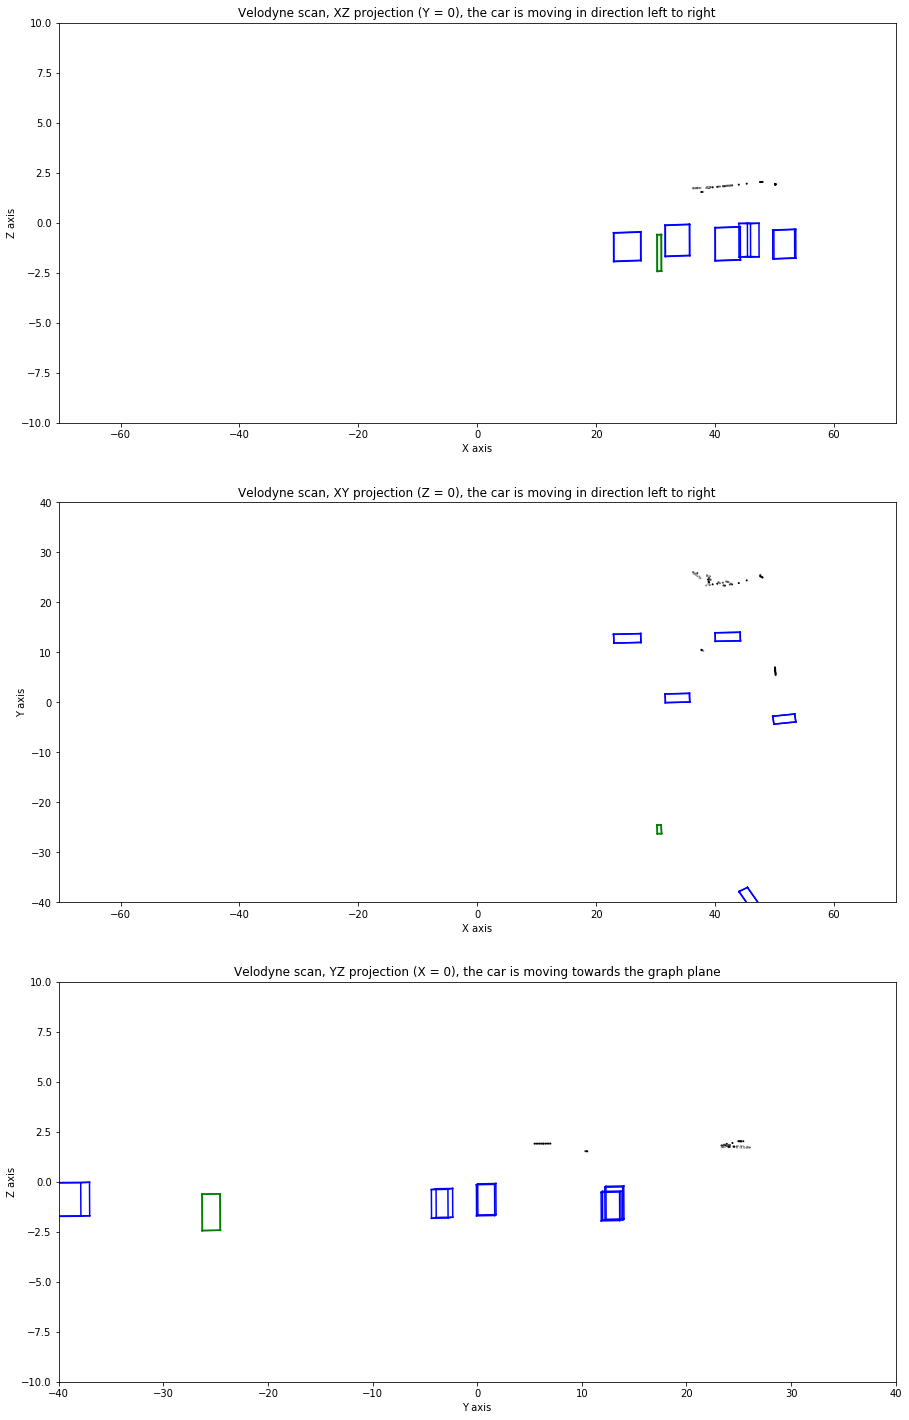

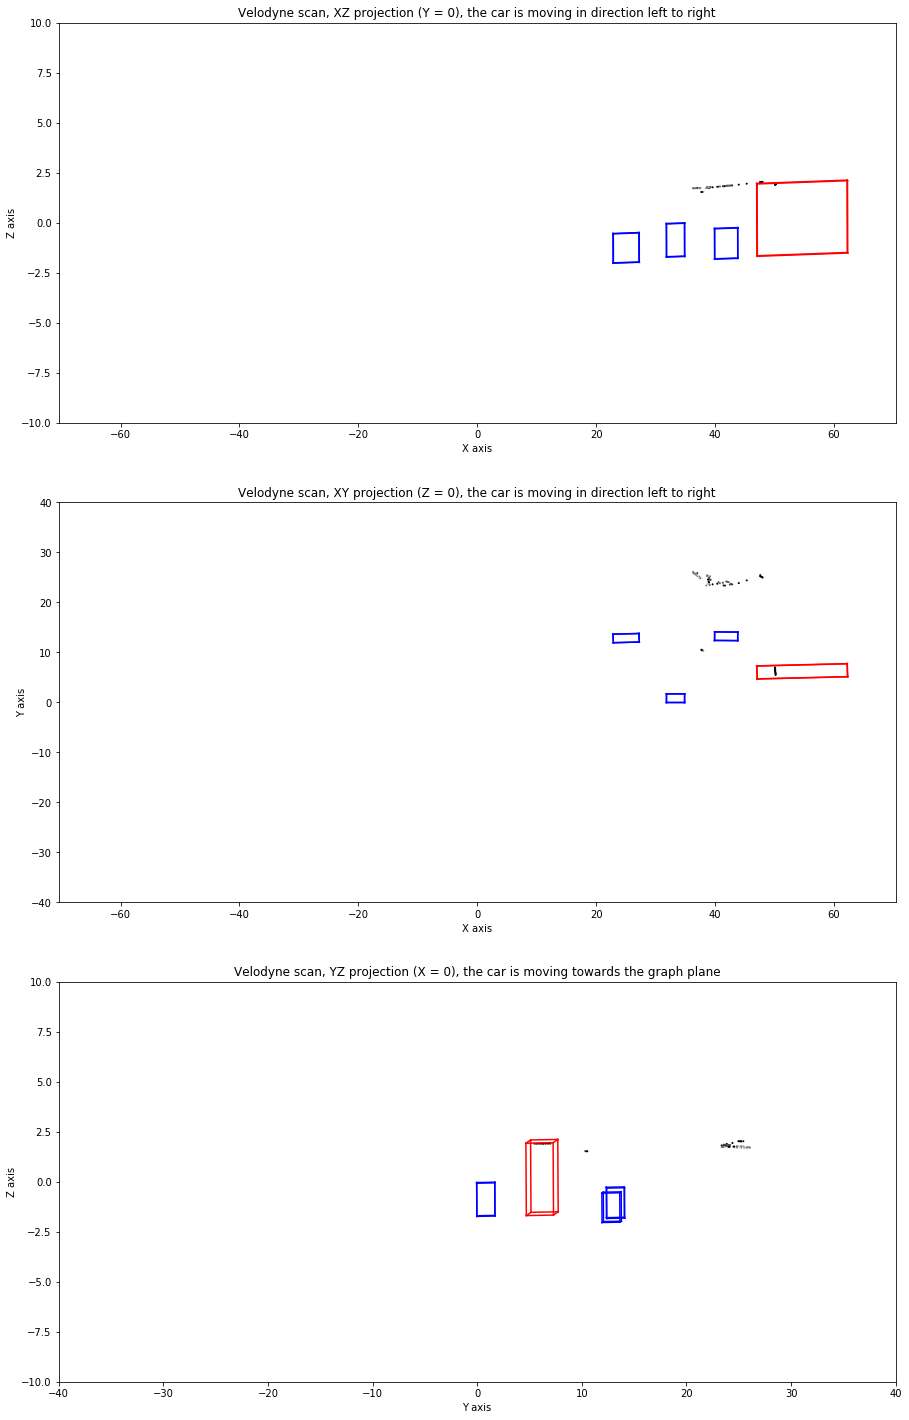

002248


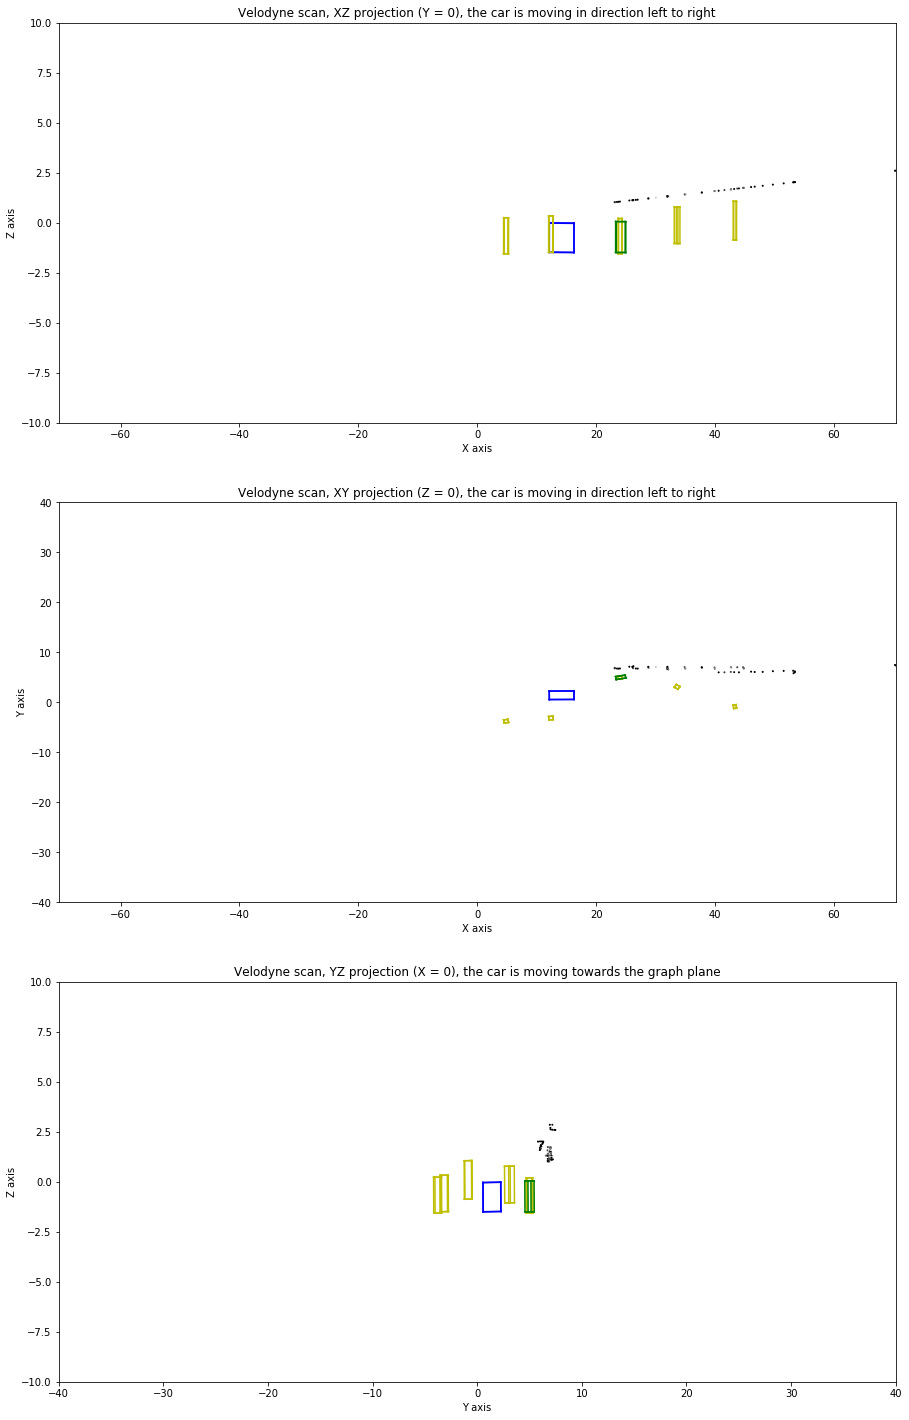

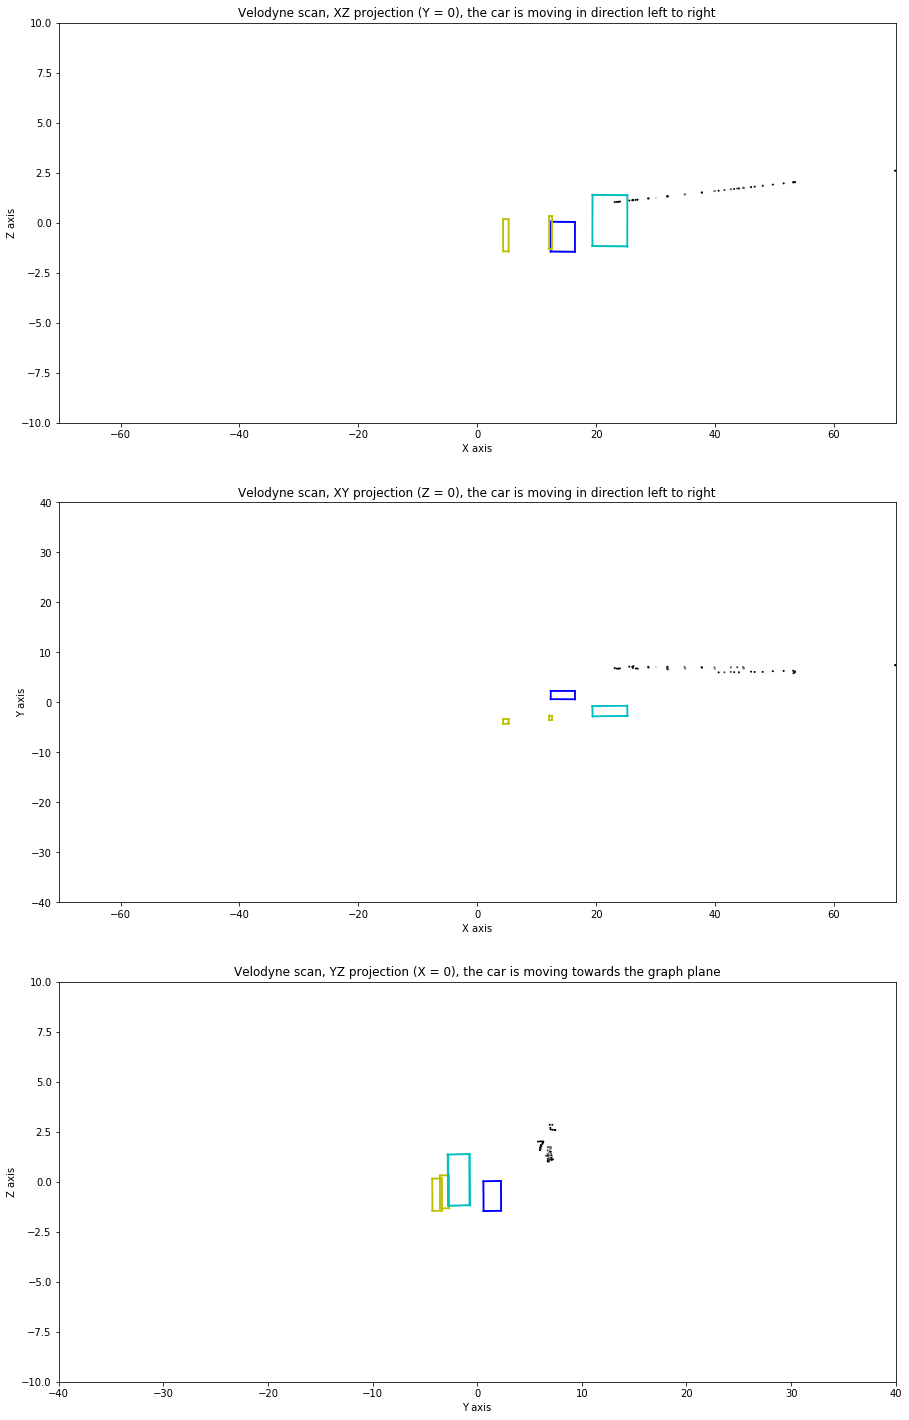

003074


In [11]:
main()